In [1]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import importlib
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})
# np.set_printoptions(linewidth=200, formatter={'float': '{:.1e}'.format})

In [2]:
GHz = 1e9
nH = 1e-9
fF = 1e-15

In [3]:
h    = 6.626e-34
e0   = 1.602e-19
Φ_0 = h/(2*e0)

In [67]:
n_plot              = 20
# EJ_by_EL_F_values   = np.linspace(1/16,15/3,n_plot)
# EC_F_by_EL_F_values = np.linspace(1/16, 2,n_plot)
EJ_by_EL_F_values   = np.linspace(1/16,2,n_plot)
EC_F_by_EL_F_values = np.linspace(0.01, 0.15,n_plot)
EL_R_by_EL_F_values = np.linspace(4/16, 7/3, 3)
EC_R_by_EL_F_values = np.linspace(1/16, 5/3, 3)
Δ_by_Lq_values = np.linspace(0.01/10, 1/50, 3)


In [68]:
def gap_vs_EJ(EJ_by_EL_F, EC_F_by_EL_F_values, EL_R_by_EL_F_values, EC_R_by_EL_F_values, Δ_by_Lq_values):
    ω01_vs_params   = np.zeros([len(EC_F_by_EL_F_values)])
    ω12_vs_params   = np.zeros([len(EC_F_by_EL_F_values)])
    ω_r_vs_params   = np.zeros([len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values) ])
    ω01_q_vs_params = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values)  ])
    ω12_q_vs_params = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values)  ])
    g_vs_params     = np.zeros([len(EC_F_by_EL_F_values), len(EL_R_by_EL_F_values), len(EC_R_by_EL_F_values), len(Δ_by_Lq_values) ])
    
    for j, EC_F_by_EL_F in enumerate(EC_F_by_EL_F_values):    
        fluxonium = sq_ext.sq_fluxonium(EJ=EJ_by_EL_F, E_C=EC_F_by_EL_F, E_L=1)  
        fluxonium.diag(3) 
        ω01_vs_params[j] = fluxonium.efreqs[1]-fluxonium.efreqs[0]
        ω12_vs_params[j] = fluxonium.efreqs[2]-fluxonium.efreqs[1]
        
        for k, EL_R_by_EL_F  in enumerate(EL_R_by_EL_F_values):
            for l, EC_R_by_EL_F in enumerate(EC_R_by_EL_F_values):
                
                if j == 0:
                    resonator = sq_ext.sq_resonator(E_C=EC_R_by_EL_F, E_L=EL_R_by_EL_F)
                    resonator.diag(2) 
                    ω_r_vs_params[k,l] = resonator.efreqs[1]-resonator.efreqs[0]
            
                for m, Δ_by_Lq in enumerate(Δ_by_Lq_values):

                    E_q = sq_ext.diag(sq_ext.hamiltonian_qubit(fluxonium=fluxonium, resonator=resonator, Δ=Δ_by_Lq))[0]
                    ω01_q_vs_params[j,k,l,m] = E_q[1]-E_q[0]
                    ω12_q_vs_params[j,k,l,m] = E_q[2]-E_q[1]
                    
                    Φf = fluxonium.flux_op(0, basis='eig')[0,1]
                    Φr = resonator.flux_op(0, basis='eig')[0,1]
                    g_vs_params[j,k,l,m] =  2 * Δ_by_Lq * Φf * Φr * ( (2*np.pi)/Φ_0 )**2 * nH * GHz * h 
                    
    return ω01_vs_params, ω12_vs_params, ω01_q_vs_params, ω12_q_vs_params, ω_r_vs_params, g_vs_params
    

In [ ]:
Data = Parallel(n_jobs=min(cpu_count(), n_plot))(delayed(gap_vs_EJ)(EJ_by_EL_F, EC_F_by_EL_F_values, EL_R_by_EL_F_values, EC_R_by_EL_F_values, Δ_by_Lq_values) for EJ_by_EL_F in EJ_by_EL_F_values)

In [82]:
ω01_vs_params   = []
ω12_vs_params   = []
ω01_q_vs_params = []
ω12_q_vs_params = []
g_vs_params     = []

for i, (Data_i) in enumerate(zip(Data)):
    ω01, ω12, ω01_q, ω12_q, ω_r, g= Data_i[0]
    ω01_vs_params  .append( ω01   )
    ω12_vs_params  .append( ω12   )
    ω01_q_vs_params.append( ω01_q )
    ω12_q_vs_params.append( ω12_q )
    if i == 0:
        ω_r_vs_params = ω_r
    g_vs_params    .append( g     )

ω01_vs_params  = np.array(ω01_vs_params  )
ω12_vs_params  = np.array(ω12_vs_params  )
ω01_q_vs_params= np.array(ω01_q_vs_params)
ω12_q_vs_params= np.array(ω12_q_vs_params)
# ω_r_vs_params  = np.array(ω_r_vs_params  )
g_vs_params    = np.array(g_vs_params    )

# Experimental parameters for the actual qubits

In [71]:
L_F_eff_1 = 26.5
L_F_eff_2 = 20.4
L_F_eff_3 = 32.2

C_F_eff_1 = 26.9
C_F_eff_2 = 22.4
C_F_eff_3 = 24.8

EJ_1 = 5.4
EJ_2 = 9.5
EJ_3 = 5.6

E_L_f_1 = (Φ_0 / (2 * np.pi)) ** 2 / (L_F_eff_1*nH) / h / GHz
E_L_f_2 = (Φ_0 / (2 * np.pi)) ** 2 / (L_F_eff_2*nH) / h / GHz
E_L_f_3 = (Φ_0 / (2 * np.pi)) ** 2 / (L_F_eff_3*nH) / h / GHz

E_C_f_1 = e0 ** 2 / (C_F_eff_1*fF) / h / GHz / 4
E_C_f_2 = e0 ** 2 / (C_F_eff_2*fF) / h / GHz / 4
E_C_f_3 = e0 ** 2 / (C_F_eff_3*fF) / h / GHz / 4

In [72]:
# fluxonium = sq_ext.sq_fluxonium(EJ=EJ_1, E_C=E_C_f_1, E_L=E_L_f_1)  
fluxonium = sq_ext.sq_fluxonium(EJ=EJ_1, L_F_eff=L_F_eff_1, C_F_eff=C_F_eff_1)  
fluxonium.diag(3) 
fluxonium.efreqs[1]-fluxonium.efreqs[0]

3.7001944890643226

In [73]:


fluxonium_coords = [(EJ_1/E_L_f_1, E_C_f_1/E_L_f_1),
                    (EJ_2/E_L_f_2, E_C_f_2/E_L_f_2),
                    (EJ_3/E_L_f_3, E_C_f_3/E_L_f_3)]

E_L_f_exp = [E_L_f_1, E_L_f_2, E_L_f_3]

omega_q_exp = [3.7001944890642844, 3.4505095260121497, 3.0342472605322786]
# fluxonium_coords = [(EJ_1, E_C_f_1),
                    # (EJ_2, E_C_f_2),
                    # (EJ_3, E_C_f_3)]

# $\omega_{01}^-$ and $\omega_{01}^+$  vs experimental parameters

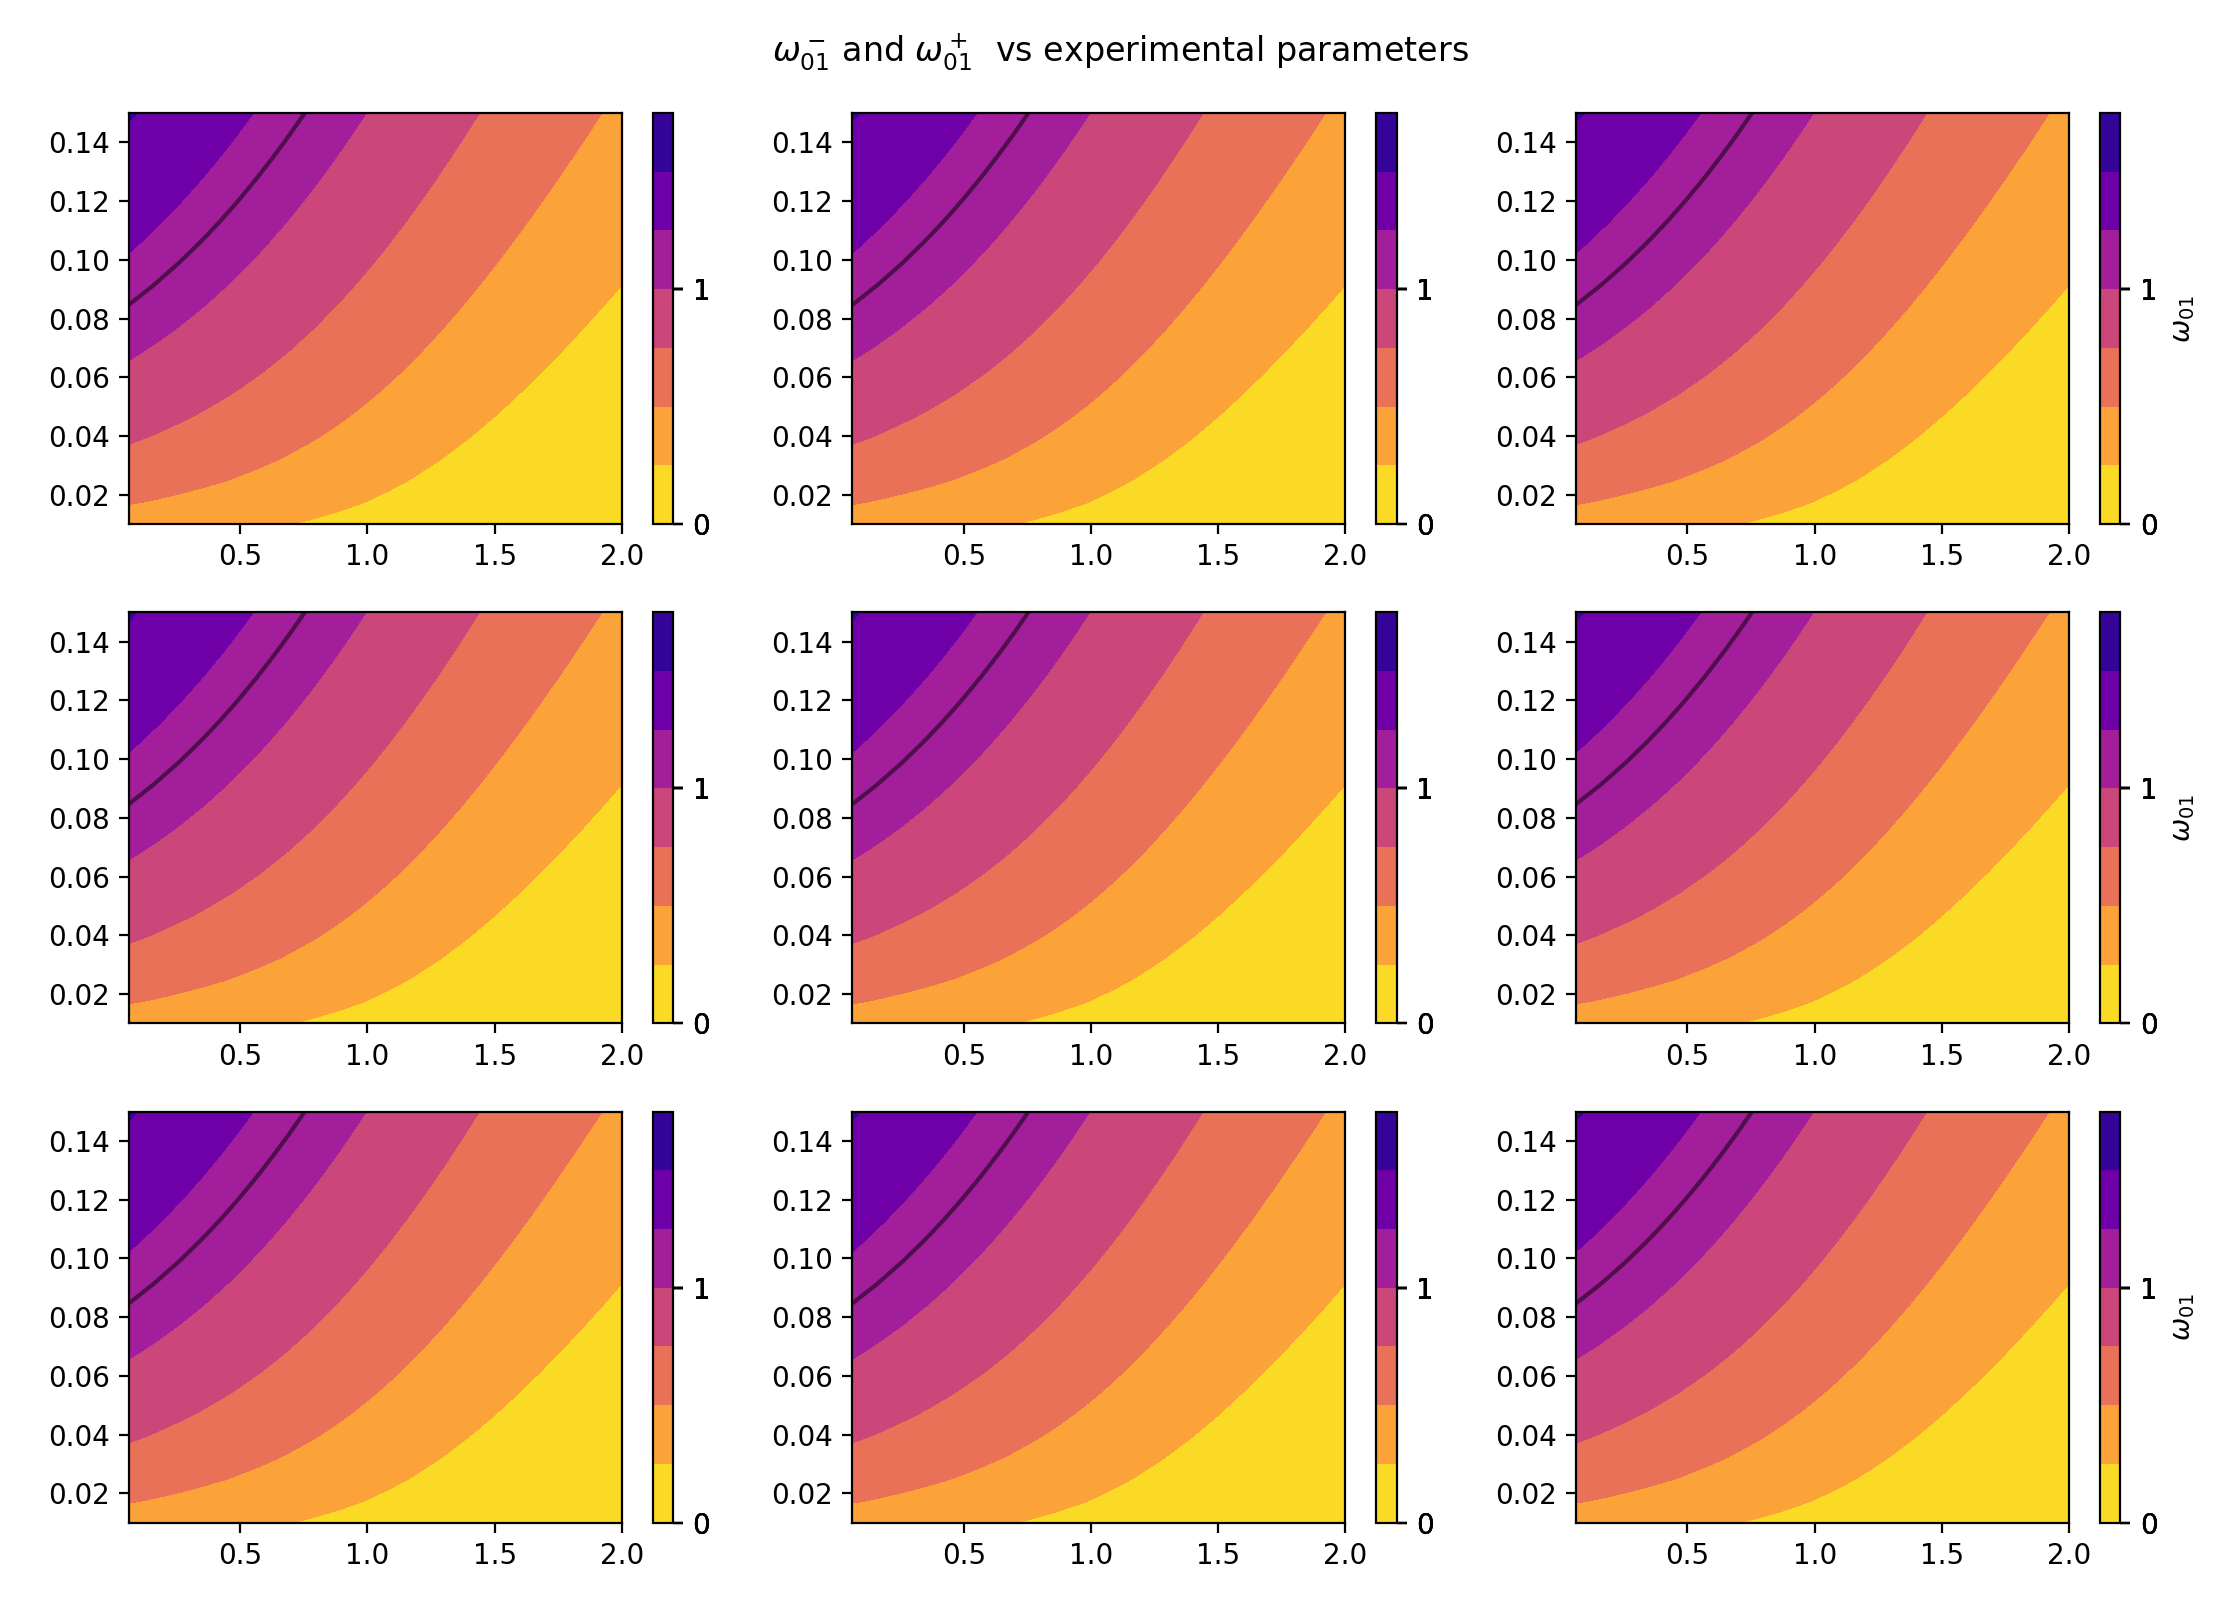

In [99]:
# EC_R_by_EL_F_values

from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = ListedColormap([ (1, 1, 1, 0), (0,0,0,0.5)])  # (1, 1, 1, 0) is white with alpha=0
bounds = [0, 0.5, 1]
norm = BoundaryNorm(bounds, cmap.N)

fig, axs = plt.subplots(ncols=3, nrows=3, figsize = np.array([14,10])*0.8, dpi=200)
for k, EL_R_by_EL_F in enumerate(EL_R_by_EL_F_values):
    for l, (ax, EC_R_by_EL_F) in enumerate(zip(axs[k,:], EC_R_by_EL_F_values)):
        ω = ω01_vs_params.T      
        ω_r = ω_r_vs_params[k,l] 
        
        # ω_min=0
        # ω_max=20
        
        x = EJ_by_EL_F_values   
        y = EC_F_by_EL_F_values 
        
        contour_plot = ax.contourf(x, y, ω, levels=6, cmap='plasma_r') 
        # ax.contour(x, y, ω, levels=[ω_r], cmap=cmap, norm=norm) 
        ax.contour(x, y, ω, levels=np.sort(ω_r_vs_params.flatten()), cmap=cmap, norm=norm) 

        # for m in range(len(Δ_values)):
        #     resonance_condition =   ( np.abs(ω-ω_r) < 10 * g_vs_params[:,:,l,k, m] )
        #     ax.contourf(x, y, resonance_condition, levels=50, cmap=cmap, norm=norm) 

        if l==2:
            cb = fig.colorbar(contour_plot, label=r'$\omega_{01}$',ticks=np.round(np.linspace(ω.min(),ω.max(),10)))
        else:
            cb = fig.colorbar(contour_plot, ticks=np.round(np.linspace(ω.min(),ω.max(),10)))
            
        # x_q,y_q = fluxonium_coords[l]
        # ax.plot(x_q,y_q,'o')
        # ax.contour(x, y, ω, levels=[omega_q_exp[l]], cmap=cmap, norm=norm) 
            
        # if k==0:
        #     ax.set_title(r'$E_{L_+}/E_{L_-}=Lr/Lq=$' + f'{EL_R_by_EL_F_values[k]}'  )
        # # ax.set_xscale('log')
        # if k==2:
        #     ax.set_xlabel('$E_J/E_{L_-}$')
        # if l==0:
        #     ax.set_ylabel(r'$E_{C_+}/E_{L_-}=Lr/Lq=$' + f'{EC_R_by_EL_F_values[k]}'+ '\n' + '$E_{C_-}/E_{L_-}$')

fig.suptitle('$\omega_{01}^-$ and $\omega_{01}^+$  vs experimental parameters')
fig.tight_layout()
fig.show()
# figs.export('fluxonium_01_vs_params.pdf', fig)

In [76]:
ω_r

array([3.084826978658, 11.473455390054, 15.929978019031])

In [9]:
fluxonium = sq_ext.sq_fluxonium(EJ=4, E_C=0.5, E_L=1)  
fluxonium.diag(3) 
fluxonium.efreqs[1]-fluxonium.efreqs[0]

0.5818734176172469

# $\omega_{02}^-$, $\omega_{01}^+$ and $\omega_{02}^+$ vs experimental parameters

# Anharmonicity vs experimental parameters